In [1]:
import networkx as nx
import numpy as np
import time
# Open adjencency list file and build the undirected graph
f=open("../lightningAdjList_26Out.txt", 'rb')
G=nx.read_multiline_adjlist(f)
f.close()

# Clean graph from smallest components
G = max(nx.connected_component_subgraphs(G), key=len)

print("Number of nodes: " + str(G.number_of_nodes()))
print("Number of edges: " + str(G.number_of_edges()))

# Read alias file and create a pub_key -> alias dic

Number of nodes: 1642
Number of edges: 8506


### Compute the average shortest path length

In [2]:
print("Average shortest path length: " + str(nx.average_shortest_path_length(G)))

Average shortest path length: 2.8951064418846832


# Removing Hubs

In [3]:
# Remove hubs until the graph is separated connected
degree = list(G.degree())

# Define a sorting function (by degree)
def degSort(node):
  return node[1]

# Sort the nodes by degree
degree.sort(reverse=True, key=degSort)

# Get the just the node ID's
nodes = [n for n, d in degree]

# Get a virgin copy of the graph
vG = G.copy()

all_pairs_shortest_paths_list = []

# Get the shortest path between all nodes in the biggest component
all_pairs_shortest_paths_list.append(dict(nx.all_pairs_shortest_path(vG)))

# Get the biggest components of the version of network without an increasing number of hubs 
for v in range(1,4):
    # Remove 40*v nodes one by one (from the biggest to the smallest degree)
    G = vG.copy()
    finalComponents = []
    for i in range(0, 40*v):
        G.remove_node(nodes[i])
    
    for component in sorted(nx.connected_component_subgraphs(G), key=len, reverse=True):
        # Only consider components that have more than 50 nodes
        if component.number_of_nodes() > 50:
            finalComponents.append(component)
            
    # Check how many components the network has left (we want 1 here)
    print(len(finalComponents))

    # Get the average shortest path length of the components left in the network
    for c in finalComponents:
        print(nx.average_shortest_path_length(c))
        
    # Get the all pairs shortest paths of the biggest component
    all_pairs_shortest_paths_list.append(dict(nx.all_pairs_shortest_path(finalComponents[0])))

1
4.129980096901396
1
5.124599905714215
1
6.235991175543649


In [4]:
# The bottleneck of a path
minCap = 10**10

# Capacity of the edge we are iteration in
edgeCap = 0

# List of lists of cumulative shortest path capacitties
pathsWithCapacityList = []

for pair_shortest_path in all_pairs_shortest_paths_list:
    
    pathsWithCapacity = [0] * 100

    # Iterate through all the shortest paths
    for source, paths in pair_shortest_path.items():
    
        # Iterate through all the paths starting from one source
        for target, path in paths.items():
        
            # Reset threshold capacity
            minCap = 10**10
            
            # Make sure we only consider paths to other nodes
            if len(path) > 1:
                
                # Iterate through edges of path and get threshold capacity
                for nodeNumber in range(0, len(path) - 1):
            
                    edgeCap = (vG.get_edge_data(path[nodeNumber], path[nodeNumber + 1]))["capacity"]
                    if edgeCap < minCap:
                        minCap = edgeCap
    
                # Save threshold against predefined capacities
                for i in range(0,100):
                    if 10000*i < minCap:
                        pathsWithCapacity[i]+=1
                    
    pathsWithCapacityList.append(pathsWithCapacity)

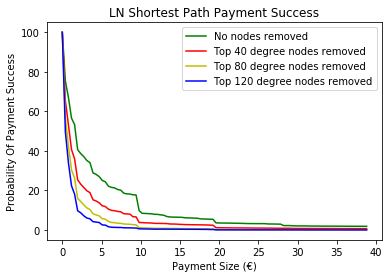

In [6]:
import matplotlib.pyplot as plt

for i, pathsWithCapacity in enumerate(pathsWithCapacityList):

    # Graph with Probability of payment success as a function of payments size (€)
    totalPaths = pathsWithCapacity[0]
    paymentProbPath = [(i/totalPaths)*100 for i in pathsWithCapacity]
    paymentSizePath = [(10000*i)*0.00003920 for i in range(0,100)]

    if i == 0:
        plt.plot(paymentSizePath, paymentProbPath, 'g', label="No nodes removed")
    elif i == 1:
        plt.plot(paymentSizePath, paymentProbPath, 'r', label="Top 40 degree nodes removed")
    elif i == 2:
        plt.plot(paymentSizePath, paymentProbPath, 'y', label="Top 80 degree nodes removed")
    elif i == 3:
        plt.plot(paymentSizePath, paymentProbPath, 'b', label="Top 120 degree nodes removed")


plt.title("LN Shortest Path Payment Success")
plt.ylabel("Probability Of Payment Success")
plt.xlabel("Payment Size (€)")

plt.legend()
plt.show()

Meaning there's a lot of liquidity hiding in the hubs.